In [237]:
# %matplotlib inline  
import import_hack
import numpy as np
import core.steps as steps
from core import data_store as ds
from core import transformer as tr
from core.common.ds_utils import print_ds_items_info
from os.path import join as pjoin
from core.search.exhaustive_searcher import ExhaustiveSearcher
from core.quantization.pq_quantizer import PQQuantizer, restore_from_clusters, build_pq_params_str, extract_pq_params_from_str
from core.metric.asymmetric_distance_computer import AsymmetricDistanceComputer
from core.evaluation.ground_truth import BrodatzGroundTruth
from core.evaluation.retrieval_perfomance import PrecisionRecallAveragePrecisionEvaluator
from core.common.file_utils import add_suffix_without_extension
from core.common.path_helper import DataStoreHelper
import math
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
global_descriptors_base_dir=r'C:\data\computation\brodatz\global_descriptors'

# Plot search perfomance

In [224]:
def plot_pq_params_perfomance(perfomance_dir, subplot_prefix, subplotvalues, perfomance_label, perfomance_extractor, prefix_path_for_plot):
    subplotname__label__x__y = {}
    for subplotvalue in subplotvalues:
        label__x__y=subplotname__label__x__y.setdefault(subplotvalue,{})
        for perfomance_filename in os.listdir(perfomance_dir):
            pq_params = extract_pq_params_from_str(perfomance_filename)
            perfomance_path = pjoin(perfomance_dir, perfomance_filename)
            perfomance_ds = ds.CSVDataStore(perfomance_path, ndarray_elem_type_read='float32')
            with perfomance_ds:
                item = perfomance_ds.get_items_sorted_by_ids([1])
                item = next(item).ravel()
                y = perfomance_extractor(item, subplotvalue)
                label = pq_params['n_quantizers']
                x__y = label__x__y.setdefault(label, {})
                x = pq_params['n_clusters']
                x__y[x] = y

    plot_filepath=add_suffix_without_extension(prefix_path_for_plot,'-plot-k-'+perfomance_label)
    plot_filepath=None
    steps.plotting_step3(subplotname__label__x__y,subplot_prefix, 'm = ', 'k', perfomance_label, save_to_file=plot_filepath)

In [225]:
n_nearest=25
n_nearest_cutoffs=[1,5,10,25]

In [226]:
perfomance_nums={'precision':1,'recall':2,'mAP':3}

In [227]:
def plot_ex_search_perfomance(perfomances_dir, perfomance_name, prefix_path_for_plot):
    subplotname__label__x__y = {}
    label__x__y=subplotname__label__x__y.setdefault('',{})
    label__kwargs={}
    for perfomance_filename in os.listdir(perfomances_dir):
        pq_params=extract_pq_params_from_str(perfomance_filename)
        if pq_params is not None:
            m=pq_params['n_quantizers']
            K=pq_params['n_clusters']
            if m==16 or K==64:
                continue
            
#         if pq_params is None or pq_params['n_quantizers']!=16:
#             print(pq_params['n_quantizers'])
#             continue
        perfomance_path = pjoin(perfomances_dir, perfomance_filename)
        perfomance_ds = ds.CSVDataStore(perfomance_path, ndarray_elem_type_read='float32')
        with perfomance_ds:
            item = perfomance_ds.get_items_sorted_by_ids([1])
            item = next(item).reshape(4, n_nearest)
            perfomance_num=perfomance_nums[perfomance_name]
            x_arr = item[0]
            y_arr = item[perfomance_num]
            x__y=dict(zip(x_arr,y_arr))
            label = perfomance_filename
            label__x__y[label]=x__y
            if 'product' in perfomance_filename:
                label__kwargs[label]={'linestyle':'dashed','markersize':10}
            else:
                label__kwargs[label]={'linestyle':':', 'markersize':10}

    plot_filepath=add_suffix_without_extension(prefix_path_for_plot,'-plot-n_nearest-'+perfomance_name)
    steps.plotting_step3(subplotname__label__x__y,'', '', 'n_nearest', perfomance_name, save_to_file=plot_filepath, label__kwargs=label__kwargs)

In [235]:
def plot_ex_search_perfomance_memory(perfomances_dir, perfomance_name, prefix_path_for_plot):
    subplotname__label__x__y = {}
    label__x__y=subplotname__label__x__y.setdefault('',{})
    label__kwargs={}
    for perfomance_filename in os.listdir(perfomances_dir):
        pq_params=extract_pq_params_from_str(perfomance_filename)
        if pq_params is not None:
            m=pq_params['n_quantizers']
            K=pq_params['n_clusters']
#             if m==16 or K==64:
#                 continue
        perfomance_path = pjoin(perfomances_dir, perfomance_filename)
        perfomance_ds = ds.CSVDataStore(perfomance_path, ndarray_elem_type_read='float32')
        with perfomance_ds:
            item = perfomance_ds.get_items_sorted_by_ids([1])
            item = next(item).reshape(4, n_nearest)
            perfomance_num=perfomance_nums[perfomance_name]
            if 'product' in perfomance_filename:
                x_arr=[m*K*4]
            elif 'bincount' in perfomance_filename:
                x_arr=[(K**m)*4]
            elif 'hist' in perfomance_filename:
                x_arr=[256*4]
            elif 'glcm' in perfomance_filename:
                x_arr=[256*256*4]
            elif 'lbp' in perfomance_filename:
                x_arr=[512*4]
                
            y_arr = [item[perfomance_num][9]]
            x__y=dict(zip(x_arr,y_arr))
            label = perfomance_filename
            label__x__y[label]=x__y
            if 'product' in perfomance_filename:
                label__kwargs[label]={'linestyle':'dashed','markersize':10}
            else:
                label__kwargs[label]={'linestyle':':', 'markersize':10}

    plot_filepath=add_suffix_without_extension(prefix_path_for_plot,'-plot-n_nearest-'+perfomance_name)
    steps.plotting_step3(subplotname__label__x__y,'', '', 'n_nearest', perfomance_name, save_to_file=plot_filepath, label__kwargs=label__kwargs)

In [236]:
prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'ex-search-memory-plot', 'precision')
plot_ex_search_perfomance_memory(pjoin(global_descriptors_base_dir, 'ex-search-perfomance-mean'),'precision', prefix_path_for_plot)

In [233]:
prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'ex-search-memory-plot', 'recall')
plot_ex_search_perfomance_memory(pjoin(global_descriptors_base_dir, 'ex-search-perfomance-mean'),'recall', prefix_path_for_plot)

In [151]:
prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'ex-search-mean-plot', 'precision')
plot_ex_search_perfomance(pjoin(global_descriptors_base_dir, 'ex-search-perfomance-mean'),'precision', prefix_path_for_plot)

In [28]:
prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'ex-search-mean-plot', 'recall')
plot_ex_search_perfomance(pjoin(global_descriptors_base_dir, 'ex-search-perfomance-mean'),'recall', prefix_path_for_plot)

In [39]:
prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'ex-search-mean-plot', 'mAP')
plot_ex_search_perfomance(pjoin(global_descriptors_base_dir, 'ex-search-perfomance-mean'),'mAP', prefix_path_for_plot)

In [12]:
def plot_exhaustive_search_perfomance(perfomances_dir, perfomance_name):
    perfomance_num=perfomance_nums[perfomance_name]
    prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'ex-search-mean-plot', perfomance_name)
    perf_extractor=lambda item, subplotvalue:item[perfomance_num*n_nearest-1+subplotvalue]
    plot_pq_params_perfomance(perfomance_dir,'n_nearest: ',n_nearest_cutoffs, perfomance_name,perf_extractor, prefix_path_for_plot)

In [24]:
def plot_adc_search_perfomance(perfomance_name, descriptor_name):
    perfomance_num=perfomance_nums[perfomance_name]
    perfomance_dir=pjoin(global_descriptors_base_dir, 'adc-search-perfomance-mean',descriptor_name)
    prefix_path_for_plot=pjoin(global_descriptors_base_dir, 'adc-search-perfomance-mean-plot',descriptor_name,perfomance_name)
    perf_extractor=lambda item, subplotvalue:item[perfomance_num*n_nearest-1+subplotvalue]
    plot_pq_params_perfomance(perfomance_dir,'n_nearest: ',n_nearest_cutoffs, perfomance_name,perf_extractor, prefix_path_for_plot)

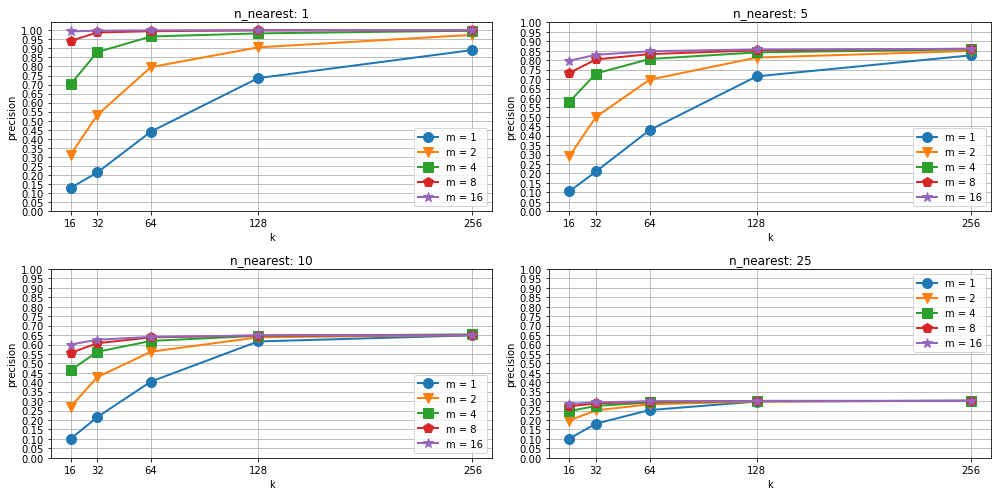

In [25]:
plot_adc_search_perfomance('precision', 'histograms')

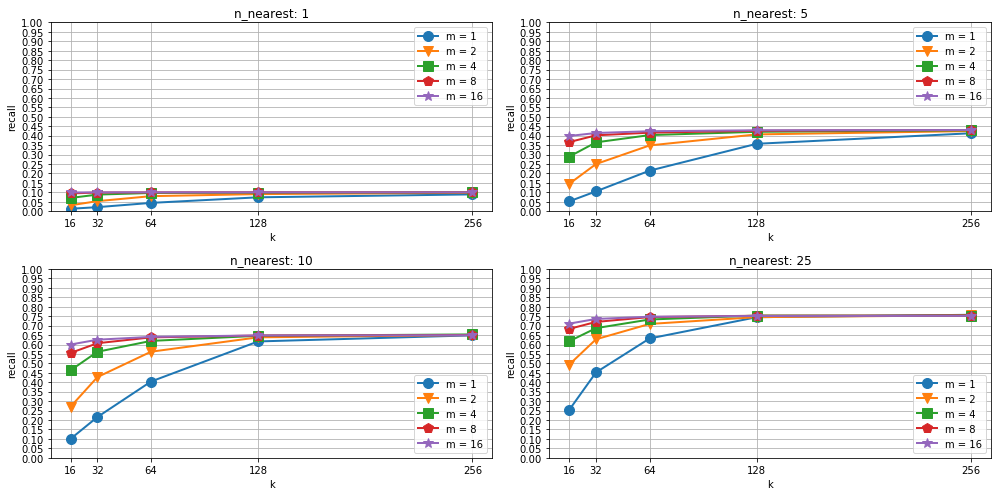

In [26]:
plot_adc_search_perfomance('recall', 'histograms')

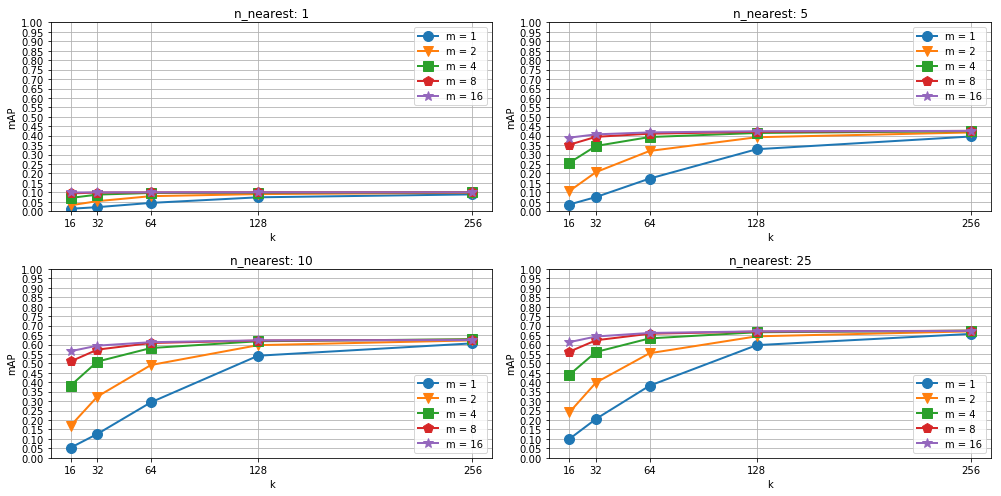

In [28]:
plot_adc_search_perfomance('mAP', 'histograms')

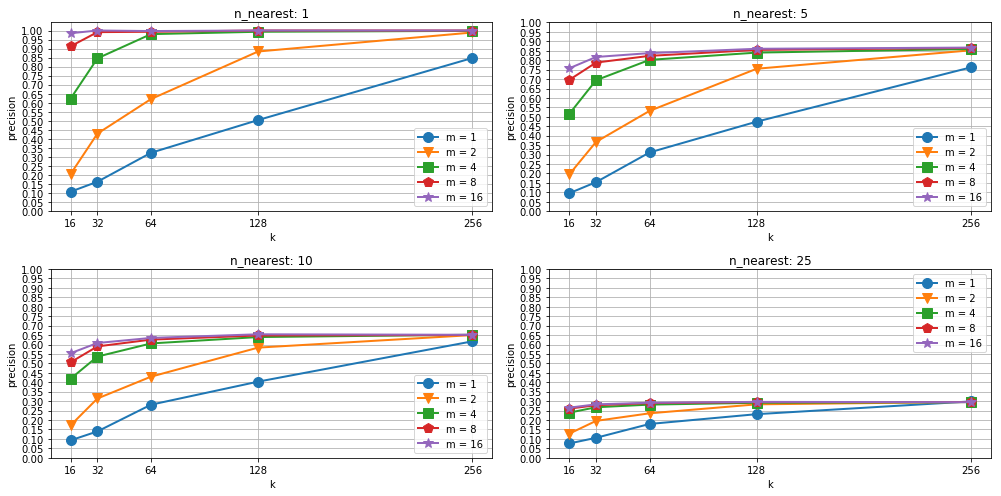

In [29]:
plot_adc_search_perfomance('precision', 'glcms')

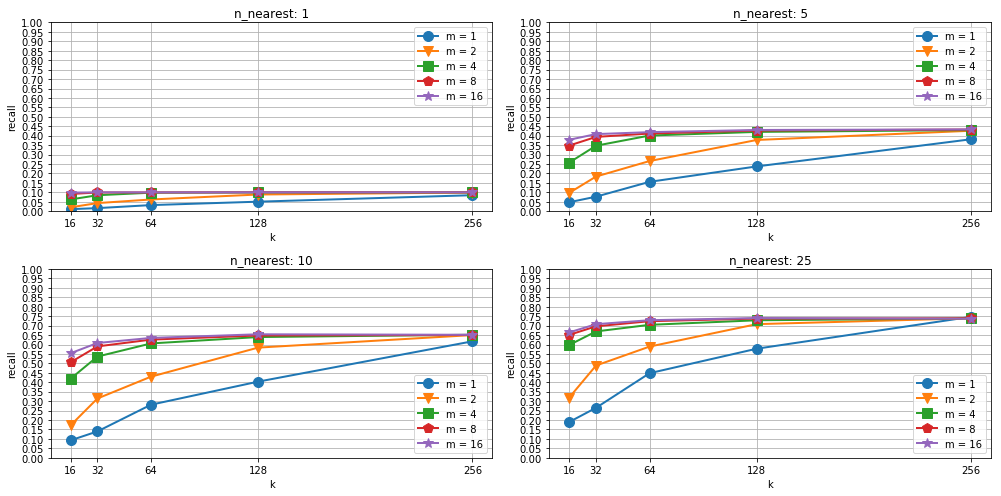

In [30]:
plot_adc_search_perfomance('recall', 'glcms')

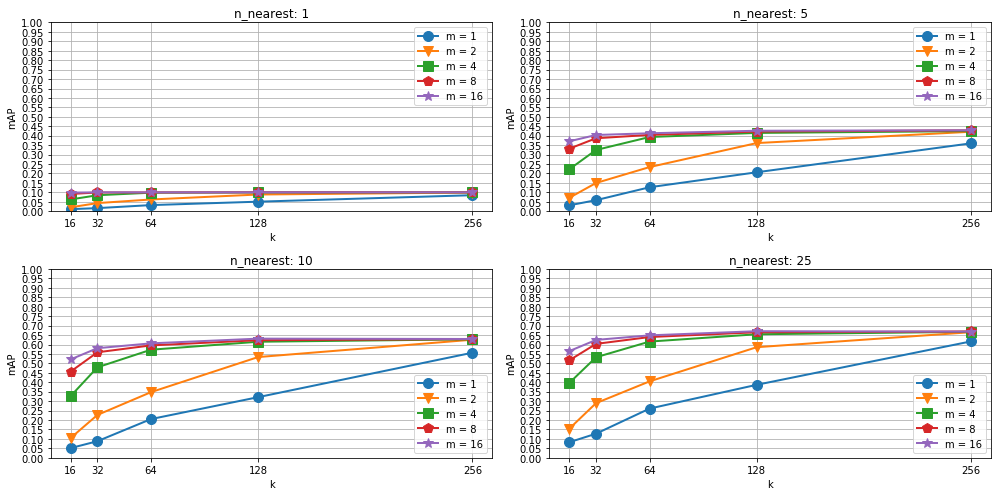

In [32]:
plot_adc_search_perfomance('mAP', 'glcms')